# Exercise 07 - Finite element method

We use finite elements to discretize a continuous domain and solve the linear elastic problem on this domain in this exercise. 



In [1]:
import torch
from torchfem import Planar
from torchfem.materials import IsotropicElasticityPlaneStress

torch.set_default_dtype(torch.double)

## Task 1 - Design

Design a planar structure with a single surface in a CAD Software of your choice. One option for such a CAD software could be Autodesk Fusion, which is free to use for students. Export the structure as "*.STEP" file and add a screenshot of your structure to this notebook.

In this solution, we choose a simplified tree shape:

![Tree](https://meyer-nils.github.io/structural_optimization/figures/tree.png)

## Task 2 - Mesh

To use FEM, we need to mesh the geometry. In this case, we use the open-source software gmsh to perform this task, which needs to be installed first. To do so, we activate our python environment via
```bash
    conda activate struct_opt
``` 
and install the package gmsh with
```bash
    pip install gmsh
```

Adapt the filename and mesh size in the following code to an appropriate value for your problem.

Info    : Reading 'tree.step'...
Info    :  - Label 'Shapes/(Unsaved)' (2D)
Info    :  - Color (0.627451, 0.627451, 0.627451) (2D & Surfaces)
Info    : Done reading 'tree.step'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000226458s, CPU 0.000238s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0253445s, CPU 0.025165s)
Info    : 791 nodes 1584 elements


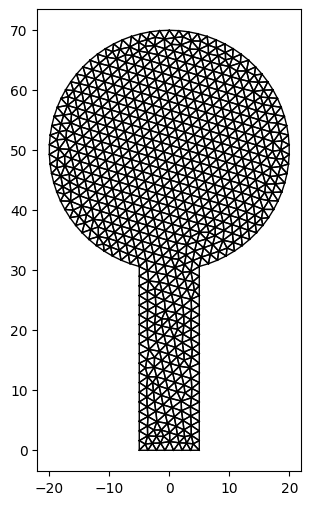

In [2]:
import gmsh

# Set gmsh options
size = 0.2
filename = "tree.step"

# Load the geometry and mesh it
gmsh.initialize()
gmsh.open(filename)
gmsh.option.setNumber("Mesh.MeshSizeFactor", size)
gmsh.model.mesh.generate(2)

# Get nodes
_, node_coords, _ = gmsh.model.mesh.getNodes()
nodes = torch.tensor(node_coords.reshape(-1, 3)[:, :2])

# Get elements
_, _, node_tags = gmsh.model.mesh.getElements(dim=2)
elements = torch.tensor((node_tags[0].reshape(-1, 3) - 1).astype(int))

# Define Material
material = IsotropicElasticityPlaneStress(E=1000.0, nu=0.3)

# Create the FEM model and visualize it
tree = Planar(nodes=nodes, elements=elements, material=material)
tree.plot(axes=True)

## Task 3 - Boundary conditions 

The `Planar` class has similar attributes to the known `Truss` class:
- `forces`: Nodal forces acting on nodes (float tensor with shape Nx2). Defaults to 0.0.
- `constraints`: Defines for each degree of freedom wether it is constrained (`True`) or not (`False`) (boolean tensor with shape Nx2). Defaults to False.  
- `displacements`: Prescribed displacements at nodes (float tensor with shape Nx2). Defaults to 0.0

Think about a load case for your structure and apply appropriate boundary conditions.

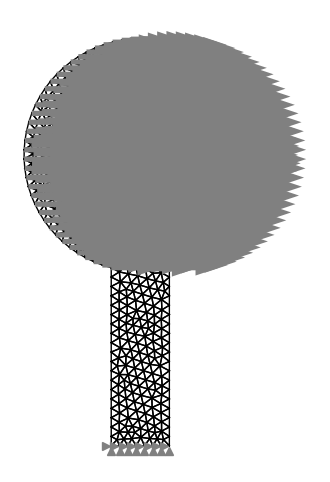

In [3]:
# Fix the roots
roots = tree.nodes[:, 1] == 0.0
tree.constraints[roots, :] = True

# Apply a wind load at the crown
crown = tree.nodes[:, 1] >= 30.0
tree.forces[crown, 0] = 0.01

# Plot mesh and loads
tree.plot()

## Task 4 - Solve and postprocessing

We solve the problem using the `solve()` function, which is already known from the `Truss` class. The function returns displacements at each node `u`, forces at each node `f`, the stress in each bar `sigma`, the deformation gradient `F`, and a state variable `state`. In this lecture, we can ignore the deformation gradient (useful for large non-linear deformations) and the state (useful for non-linear materials like plasticity).

In [4]:
u, f, sigma, F, state = tree.solve()

a) Plot the deformed shape with color indicating the displacement magnitude.

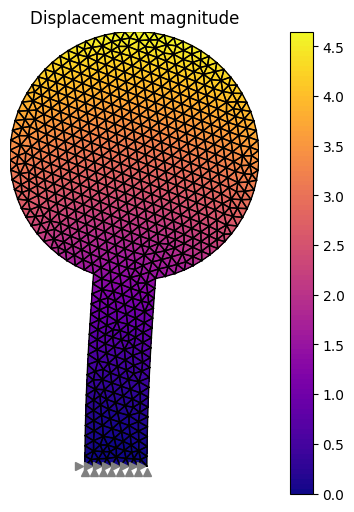

In [5]:
# Turn off forces for visualization
tree.forces[:] = 0.0

tree.plot(
    u=u,
    node_property=torch.linalg.norm(u, dim=1),
    colorbar=True,
    cmap="plasma",
    title="Displacement magnitude",
)

b) Compute the v. Mises stress and plot it on the deformed shape with color indicating the stress. 

In [6]:
mises = torch.sqrt(
    sigma[:, 0, 0] ** 2
    - sigma[:, 0, 0] * sigma[:, 1, 1]
    + sigma[:, 1, 1] ** 2
    + 3 * sigma[:, 1, 0] ** 2
)

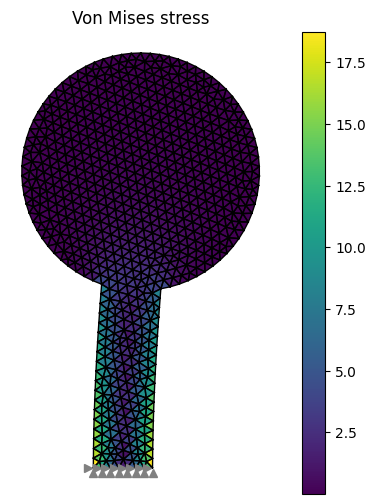

In [7]:
tree.plot(
    u=u,
    element_property=mises,
    colorbar=True,
    cmap="viridis",
    title="Von Mises stress",
)